<img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> <div style="font-size: 25px">Data Science 2: Advanced Topics in Data Science</div>

## Lab 11: Fine-Tuning with LoRA and Quantization Using Hugging Face
**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

<hr style="height:2pt">

### 🎯 Lab Goals

In this notebook, you'll learn how to fine-tune a transformer model using **LoRA (Low-Rank Adaptation)** and **4-bit quantization** — the same tools you'll use in Homework 5.

The objectives of this lab are to:

1. Introduce and motivate **LoRA** as a method for parameter-efficient fine-tuning
2. Explain how **quantization** reduces memory and speeds up inference
3. Show how to apply these techniques using Hugging Face Transformers, PEFT, and bitsandbytes
4. Demonstrate the Hugging Face `Trainer` API as an alternative to the Keras .fit()
5. Guide you through each step in a **runnable, motivated example** using the `emotion` dataset and a BERT-based model

We’ll carefully walk through:
- Loading and tokenizing text data
- Loading a quantized model
- Preparing the model for LoRA fine-tuning
- Selecting which submodules to adapt
- Training using the Hugging Face `Trainer` API

This notebook assumes no prior experience with LoRA, PEFT, or low-bit inference — **we are introducing these ideas for the first time**.

---

### 🤔 Background: LoRA and Quantization in Modern Fine-Tuning

Fine-tuning large pretrained models is central to modern NLP and vision tasks, but it can be prohibitively expensive — in memory, compute, and storage. Two techniques help make fine-tuning more practical, especially for academic and real-world constraints:

#### 🧠 Low-Rank Adaptation (LoRA)
LoRA is a method that injects **small trainable adapter matrices** into specific layers (typically attention projections) while **freezing the rest of the model**. It works by decomposing updates into low-rank approximations:
- Instead of training a full matrix `W`, we train `A @ B`, where `A` and `B` have much smaller dimensions.
- These updates are added to the frozen weight during the forward pass: `W' = W + ΔW = W + A @ B`
- During backpropagation, **only A and B are updated**

This approach has two main benefits:
- **Massive reduction in trainable parameters**
- **Compatible with frozen, quantized backbones**, which reduces memory and speeds up training

You’ll use LoRA through the 🤗 PEFT library, which simplifies applying it to standard Hugging Face models.

Key API component:
```python
from peft import LoraConfig, get_peft_model
```

Parameters you’ll specify:
- `r`: rank of low-rank matrices (e.g., 8 or 16)
- `lora_alpha`: scaling of adapter output
- `target_modules`: which attention submodules to adapt (e.g., `query`, `key`, `value` for BERT)

#### 💾 Quantization (via bitsandbytes)
Quantization means loading model weights at **reduced precision** — typically 8-bit or 4-bit instead of 32-bit. For very large models, this reduces GPU memory usage and allows inference on consumer hardware.


When combined with LoRA (which adds a small number of trainable float32 weights), this allows for **efficient and stable fine-tuning**.

#### 🧰 Additional Setup: `prepare_model_for_kbit_training()`
Before applying LoRA to a quantized model, we need to:
- Freeze the backbone
- Ensure that sensitive layers (e.g., LayerNorm) remain in full precision

```python
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)
```

This setup is particularly useful for models like BERT that you can quantize **and** adapt with LoRA.


### 📂 Step 1: Load and Inspect the Emotion Dataset

We'll use the [`emotion`](https://huggingface.co/datasets/dair-ai/emotion) dataset from Hugging Face, which contains over 20k short English text examples, each labeled with **one of six emotions**:

- `anger`, `disgust`, `fear`, `joy`, `sadness`, `surprise`

These are short informal sentences, many sourced from social media or microblogs.

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset and tokenizer
raw_ds = load_dataset("emotion")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [2]:
# Convert HF dataset to pandas for inspection
df = pd.DataFrame(raw_ds["train"])

# Look at the first few rows
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [3]:
# Get class label names from the dataset metadata
label_names = raw_ds["train"].features["label"].names
print("Class labels:", label_names)

Class labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


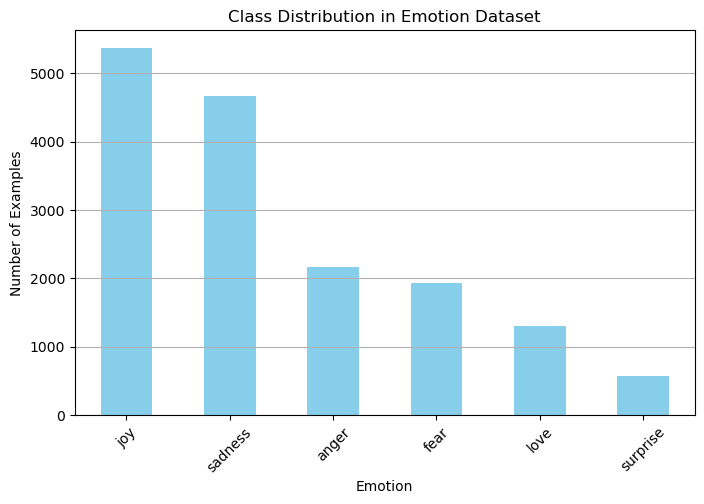

In [4]:
# Replace label IDs with label names for plotting
df["label_name"] = df["label"].map(lambda i: label_names[i])

# Plot class frequencies
plt.figure(figsize=(8, 5))
df["label_name"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Class Distribution in Emotion Dataset")
plt.xlabel("Emotion")
plt.ylabel("Number of Examples")
plt.xticks(rotation=45)
plt.grid(True, axis='y')

#### 🧩 Tokenizing the Text Data

Transformer models like BERT expect tokenized input — that is, numerical IDs representing word pieces (subword tokens). We use the `AutoTokenizer` to:

- split raw text into tokens
- add special `[CLS]` and `[SEP]` markers
- pad and truncate sequences to a fixed length

In [5]:
# Define a tokenization function that maps raw text to input IDs and attention masks
def preprocess(example):
    tokenized = tokenizer(
        example["text"],
        padding="max_length",   # Pad all sequences to the same max length
        truncation=True,        # Truncate longer sequences to fit max length
        max_length=128          # Reasonable max length for short texts
    )
    tokenized["label"] = example["label"]  # Make sure to keep labels!
    return tokenized

The Hugging Face `datasets` library lets us apply this function efficiently to the entire dataset using `.map(batched=True)`.

Finally, we use `.set_format(type="torch", ...)` to convert the dataset into tensors ready for PyTorch training.

At this point, we're ready to load the model and start fine-tuning.

In [6]:
# Split training set into train/test (80/20 split)
tokenized_ds = raw_ds["train"].train_test_split(
    test_size=0.2,
    stratify_by_column="label"  # ensures each class is proportionally represented
)


# Apply the tokenizer to the dataset in batched mode
tokenized_ds = tokenized_ds.map(preprocess, batched=True)

# Set the output format so PyTorch can use it directly
tokenized_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

#### 🔎 Example: What Does a Tokenized Input Look Like?

After preprocessing, each example now contains:

- `input_ids`: token IDs for the BERT vocabulary
- `attention_mask`: tells the model which tokens are padding (`0`) vs. real input (`1`)
- `label`: the emotion class index

Let’s inspect a single example so you can see exactly what will be fed into the model.


In [7]:
# Look at the first tokenized training example
example = tokenized_ds["train"][0]

# Show token IDs and attention mask
print("input_ids:     ", example["input_ids"])
print("attention_mask:", example["attention_mask"])
print("label (index): ", example["label"])
print("label (name):  ", label_names[example["label"]])

input_ids:      tensor([  101, 10047,  2667,  2000,  2424,  3971,  2000,  5587,  2062, 22746,
         2046,  2026,  6134,  2302,  3110,  3294, 13394,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0

#### 🔁 Decoding Tokens Back to Text

The tokenizer can also **reverse** the tokenization process — converting `input_ids` back into a string.

This helps you debug whether padding, truncation, or special tokens are behaving as expected.


In [8]:
# Decode the input_ids back to a human-readable string
decoded_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)

print("📝 Decoded text:", decoded_text)

📝 Decoded text: im trying to find ways to add more sewing into my schedule without feeling completely overwhelmed


#### 🔬 Show Special Tokens

By default, we strip out special tokens like `[CLS]` and `[SEP]` when decoding.

These tokens are important! BERT uses `[CLS]` to represent the entire sequence and `[SEP]` to separate segments (e.g., question + context).

Let’s decode again, this time **with** special tokens shown.


In [9]:
# Decode again, but keep special tokens to show model structure
decoded_with_specials = tokenizer.decode(example["input_ids"], skip_special_tokens=False)

print("Decoded with special tokens:", decoded_with_specials)

Decoded with special tokens: [CLS] im trying to find ways to add more sewing into my schedule without feeling completely overwhelmed [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


#### ⚖️ Applying Class Weights in the Loss Function

Since our dataset is class-imbalanced, we can compensate by using **class weights** in the loss.

To do this with Hugging Face's `Trainer` (which we will see soon), we:
1. Compute weights from label frequencies
2. Define a custom loss function using `torch.nn.CrossEntropyLoss(weight=...)`
3. Subclass `Trainer` and override the `compute_loss()` method

This way, the model is **penalized more for mistakes on rare classes**, improving fairness in training.


In [10]:
# Compute class weights for use in custom Trainer
from collections import Counter
import torch

train_labels = tokenized_ds["train"]["label"]
train_labels = train_labels.tolist()  # Convert from tensor to list

label_freqs = Counter(train_labels)
num_classes = len(label_names)
total = sum(label_freqs.values())

class_weights = [
    total / (num_classes * label_freqs.get(i, 1))  # fallback avoids division by zero
    for i in range(num_classes)
]

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)  # leave on CPU for now

print("Class weights:", class_weights)

Class weights: [0.5714795963925351, 0.4972804972804973, 2.045381911153723, 1.2352827639451844, 1.377232623197762, 4.657933042212518]


---

### 🧮 Step 2: Loading a Quantized Model

In the cell cell below, we use `bitsandbytes` via `transformers` to load a 4-bit quantized version of `bert-base-uncased` for sequence classification.

- `BitsAndBytesConfig` lets us define how to quantize the weights and how computation is done.
- `bnb_4bit_quant_type='nf4'` uses a NormalFloat4 quantization scheme, which generally performs better than standard int4 quantization.
- `bnb_4bit_compute_dtype=torch.float16` allows computation to happen in half precision, saving memory while remaining relatively stable.
- `device_map='auto'` tells Transformers to spread the model across available devices (e.g., GPUs or CPU) automatically.

This setup reduces memory footprint significantly and makes it possible to fine-tune large models — especially when combined with LoRA — on modest hardware.

In [11]:
import torch
from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig

# Define the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,                       # Load model weights in 4-bit precision to reduce memory use
    bnb_4bit_compute_dtype=torch.float16,    # Perform computations in 16-bit floating point (good trade-off between speed and stability)
    bnb_4bit_quant_type="nf4"                # Use the 'nf4' (NormalFloat4) quantization scheme for improved accuracy
)

# Load a BERT model with 6 output classes (for the 'emotion' dataset), using the above quantization config
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",                     # Pretrained BERT model
    num_labels=6,                            # 6-class classification task (anger, joy, sadness, etc.)
    quantization_config=quantization_config,# Apply 4-bit quantization at load time
    device_map="auto"                        # Automatically place layers on available GPU(s) or fallback to CPU
)

2025-04-18 01:08:08.178591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-18 01:08:08.178636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-18 01:08:08.179358: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 01:08:08.184030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of BertForSequenceClas

---

### 🥶 Step 3: Prepare the Model for Low-Bit Fine-Tuning

Once we've loaded a quantized model, we still need to prepare it for training. Why?

When weights are quantized (e.g., to 4-bit), they are no longer suitable for gradient-based optimization — they're just too coarse. So when we use **LoRA** to fine-tune these models, we freeze most of the quantized weights and only train a small number of added adapter weights.

However, a few parts of the model (especially **LayerNorm layers**) are sensitive to precision and may still need to be trainable — and in float32.

This is where the `prepare_model_for_kbit_training()` utility from the `peft` library comes in. It does three important things:
- **Freezes all quantized layers** to avoid modifying low-precision weights
- **Leaves LayerNorm layers trainable**, which can stabilize training
- **Casts them to float32** to ensure numerical stability in backpropagation
- **Ensures the model is compatible** with downstream PEFT LoRA injection

This step is usually recommended before applying LoRA to quantized models.


In [12]:
from peft import prepare_model_for_kbit_training

# Modify the model in-place to support LoRA + quantization fine-tuning
model = prepare_model_for_kbit_training(model) 

---

### ⚙️ Step 4: Configure and Apply LoRA

Now that we’ve prepped the quantized model, we’re ready to inject **LoRA adapters**.

LoRA stands for **Low-Rank Adaptation** — it’s a way to introduce a small number of trainable parameters (low-rank matrices) into a much larger, frozen model. Instead of updating all the weights of a layer, LoRA introduces new matrices `A` and `B` such that the update is `W + A @ B`, where `W` is frozen and `A @ B` is trainable.

The 🤗 `peft` library makes it easy to apply LoRA to Hugging Face models.

---

#### 🔧 `LoraConfig`

This class tells PEFT **how and where** to apply the LoRA adapters. The key parameters you’ll need are:

- `r`: the rank of the low-rank matrices (smaller = fewer parameters, but less expressive)
- `lora_alpha`: a scaling factor that controls how strong the LoRA updates are
- `target_modules`: the names of the submodules (e.g., attention projections) where adapters should be inserted
- `task_type`: what kind of task this is (e.g., sequence classification)

When using BERT, the attention projection layers are typically named `"query"`, `"key"`, and `"value"` — you can verify this by printing `model.named_modules()`.

---

In [13]:
from peft import LoraConfig, get_peft_model, TaskType

# Define how LoRA should be applied
lora_config = LoraConfig(
    r=16,                                  # Rank of the low-rank matrices (small = fewer params)
    lora_alpha=32,                         # Scaling factor for adapter output
    lora_dropout=0.05,                     # Dropout applied to adapter output (adds regularization)
    bias="none",                           # Don't train bias terms
    task_type=TaskType.SEQ_CLS,            # Sequence classification task (sets defaults internally)
    target_modules=["query", "key", "value"]  # BERT attention projection layers to adapt
)

#### 🤖 `get_peft_model(...)`

Once you define the `LoraConfig`, you pass it along with the model to `get_peft_model(...)`, which:
- Injects the LoRA adapters into the specified submodules
- Marks the new weights as trainable (and leaves the rest frozen)
- Wraps the model with PEFT’s training-aware structure

This gives you a modified model ready for lightweight fine-tuning!

In [14]:
# Inject LoRA adapters into the frozen, quantized BERT model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 889,350 || all params: 110,376,204 || trainable%: 0.8057


At this point:
- Most of the model is frozen (not trainable)
- Only the LoRA adapters and some LayerNorms are trainable
- We're ready to fine-tune efficiently!

---

### 🦮 Introducing: Hugging Face's `Trainer` API

Now that we've configured our model (quantized + LoRA) and datasets, we're ready to train. Instead of using Keras's `.fit()` method — which you’ve seen in previous assignments — we’ll now use Hugging Face’s `Trainer` API.

The `Trainer` handles:
- batching and shuffling your dataset
- running the training and evaluation loop
- logging and saving progress
- computing metrics like accuracy

This API gives us **more control and compatibility** with Hugging Face models than `Keras.fit()` — especially when working with quantized models or LoRA-injected modules.

---

### 📏 Step 5: Define Evaluation Metrics for the Hugging Face Trainer

The Hugging Face `Trainer` API gives us an easy way to fine-tune models, but it doesn’t compute evaluation metrics for you unless you explicitly tell it how.

To evaluate model performance during training and at the end of each epoch, the Trainer expects a **custom function** you define and pass via the `compute_metrics` argument.

---

#### 📥 What does this function receive?

The function takes a single argument: `eval_pred`, which is a tuple containing:
- `logits`: raw model outputs (before softmax)
- `labels`: the true class labels

---

#### 📤 What should it return?

It should return a **dictionary of metric names and values** that will be logged and reported by the Trainer during evaluation.

---

#### ✅ Metrics for This Task

We define two evaluation metrics for the `emotion` classification problem:

1. **Accuracy** — overall percentage of correct predictions.
2. **F1 Macro** — the average F1 score computed separately for each class, useful for handling class imbalance (some emotions are less frequent than others).

These give us a more complete picture of how well the model performs across all classes.


In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# This function is passed to the Hugging Face Trainer to compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred                # Tuple containing model outputs and true labels
    preds = np.argmax(logits, axis=1)         # Convert logits to predicted class indices

    return {
        "accuracy": accuracy_score(labels, preds),           # Overall classification accuracy
        "f1_macro": f1_score(labels, preds, average="macro") # Balanced F1 across all emotion classes
    }

---

### ⚙️ Step 6: Configure the Trainer

Hugging Face provides the `Trainer` API to simplify training. It handles batching, gradient updates, logging, evaluation, and [more](https://huggingface.co/docs/transformers/en/main_classes/trainer) — so you don’t have to write the full training loop yourself.

In our particular example we will configure training in two steps:

---

#### 🧾 A. Define TrainingArguments

This object specifies:
- Where to save outputs
- Batch size for training and evaluation
- How often to evaluate
- How many epochs to train
- Logging and reporting options

---

#### ⚒️ B. Subclass Trainer to Support Weighted Loss (Optional)

To address class imbalance, we subclass the default `Trainer` and override the loss function using `compute_loss()`:

- We use `CrossEntropyLoss(weight=...)` with precomputed class weights
- This ensures the model **pays more attention to rare classes**
- If you didn’t compute class weights, you could still use the standard `Trainer` instead

In [16]:
# Import the Hugging Face Trainer and TrainingArguments classes
from transformers import TrainingArguments, Trainer

# Define training configuration
training_args = TrainingArguments(
    output_dir="./results",                 # Where to save logs, models, etc.
    per_device_train_batch_size=8,          # Training batch size per device (e.g., GPU)
    per_device_eval_batch_size=8,           # Evaluation batch size per device
    eval_strategy="epoch",                  # Evaluate once per epoch
    num_train_epochs=3,                     # For demo purposes, just 1 epoch
    logging_steps=10,                       # Log training loss every 10 steps
    save_strategy="no",                     # Skip checkpoint saving to reduce clutter
    report_to="none"                        # Disable integrations like WandB or TensorBoard
)

In [18]:
from transformers import Trainer
import torch.nn as nn

# Subclass Trainer to override loss computation
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Use weighted cross-entropy loss (moving weights to GPU device here)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [19]:
# Use the custom Trainer class that supports class-weighted loss
trainer = WeightedTrainer(
    model=model,                        # The LoRA+quantized model
    args=training_args,                 # Training configuration
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,               # Required for padding/collation
    compute_metrics=compute_metrics    # Accuracy + F1
)

/tmp/ipykernel_5917/3665079456.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


---

### 🚀 Step 7: Train the Model

Launch training — this should complete quickly due to the small dataset and parameter-efficient setup.

In [20]:
trainer.train() # Train it!

/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.340800,1.242445,0.648750,0.456756
2,0.783000,0.743114,0.758125,0.691171
3,0.760300,0.640729,0.788125,0.740977


/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=4800, training_loss=1.0657496799031894, metrics={'train_runtime': 500.9959, 'train_samples_per_second': 76.647, 'train_steps_per_second': 9.581, 'total_flos': 2552184845107200.0, 'train_loss': 1.0657496799031894, 'epoch': 3.0})

### 📊 Step 8: Make Predictions and Visualize Model Performance

Once training is complete, we often want to evaluate **how** the model is making predictions — not just how many it gets right.

The Hugging Face `Trainer` makes this easy with the `predict()` method.

---

#### 🔮 Making Predictions

Calling `trainer.predict(dataset)` returns:
- `predictions`: raw logits (unnormalized model outputs)
- `label_ids`: true labels
- `metrics`: any metrics computed by `compute_metrics`

We use `np.argmax(logits, axis=1)` to convert logits into predicted class indices.

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Run predictions on the test set
pred_output = trainer.predict(tokenized_ds["test"])

logits = pred_output.predictions             # Raw model outputs
true_labels = pred_output.label_ids          # Ground truth labels
predicted_labels = np.argmax(logits, axis=1) # Convert logits to predicted class indices

---

#### ⁉️ Confusion Matrix

A **confusion matrix** is a great diagnostic tool for multi-class classification. It tells us:

- Which classes the model is often **confusing**
- Whether errors are **systematic** (e.g., always predicting “joy”)
- Where we might want to collect more data or refine our architecture

Each row in the matrix represents the **true class**, and each column represents the **predicted class**.

The diagonal shows **correct predictions** — everything else is an error.

<Figure size 800x600 with 0 Axes>

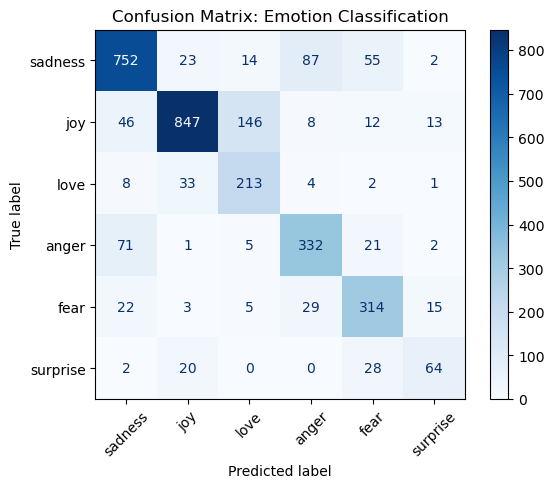

In [27]:
# Compute and plot the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display labels: class names from the dataset
class_labels = raw_ds["train"].features["label"].names


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Emotion Classification")
plt.grid(False)

🌈 **The End**